In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
# Ensure these filenames match the ones in your folder exactly
sentiment_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')

# Basic Audit (Part A requirement)
print(f"Sentiment Rows: {sentiment_df.shape[0]} | Trader Rows: {trader_df.shape[0]}")
print(f"Missing in Trader Data:\n{trader_df.isnull().sum()[trader_df.isnull().sum() > 0]}")

# Display first few rows to verify
sentiment_df.head()

Sentiment Rows: 2644 | Trader Rows: 211224
Missing in Trader Data:
Series([], dtype: int64)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
# 1. Convert Sentiment 'date' to datetime
sentiment_df['date_dt'] = pd.to_datetime(sentiment_df['date'])

# 2. Convert Trader 'Timestamp' (ms) to normalized Date
# We use unit='ms' and .dt.normalize() to remove the time component for a daily join
trader_df['date_dt'] = pd.to_datetime(trader_df['Timestamp'], unit='ms').dt.normalize()

# 3. Merge Datasets
# We keep only rows where we have both trading data and sentiment data
df = pd.merge(trader_df, sentiment_df, on='date_dt', how='inner')

# 4. Create Win/Loss indicator for later metrics
df['is_win'] = df['Closed PnL'] > 0

print(f"Merged Dataset Size: {df.shape}")

Merged Dataset Size: (184263, 22)


In [ ]:
# Grouping by Account and Date to find behavior patterns
daily_metrics = df.groupby(['Account', 'date_dt', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Account', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    total_volume=('Size USD', 'sum')
).reset_index()

# Calculate Daily Win Rate
win_rates = df.groupby(['Account', 'date_dt'])['is_win'].mean().reset_index(name='win_rate')
daily_metrics = pd.merge(daily_metrics, win_rates, on=['Account', 'date_dt'])

# View the engineered table
daily_metrics.head()

,Account,date_dt,classification,daily_pnl,trade_count,avg_trade_size,total_volume,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,462,14810.891818,6842632.02,0.025974
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,3356,16345.241940,54854631.95,0.405542
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,320,2492.749906,797679.97,0.531250
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,3533,1693.351684,5982611.50,0.435041
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,5,6070.200000,30351.00,0.000000


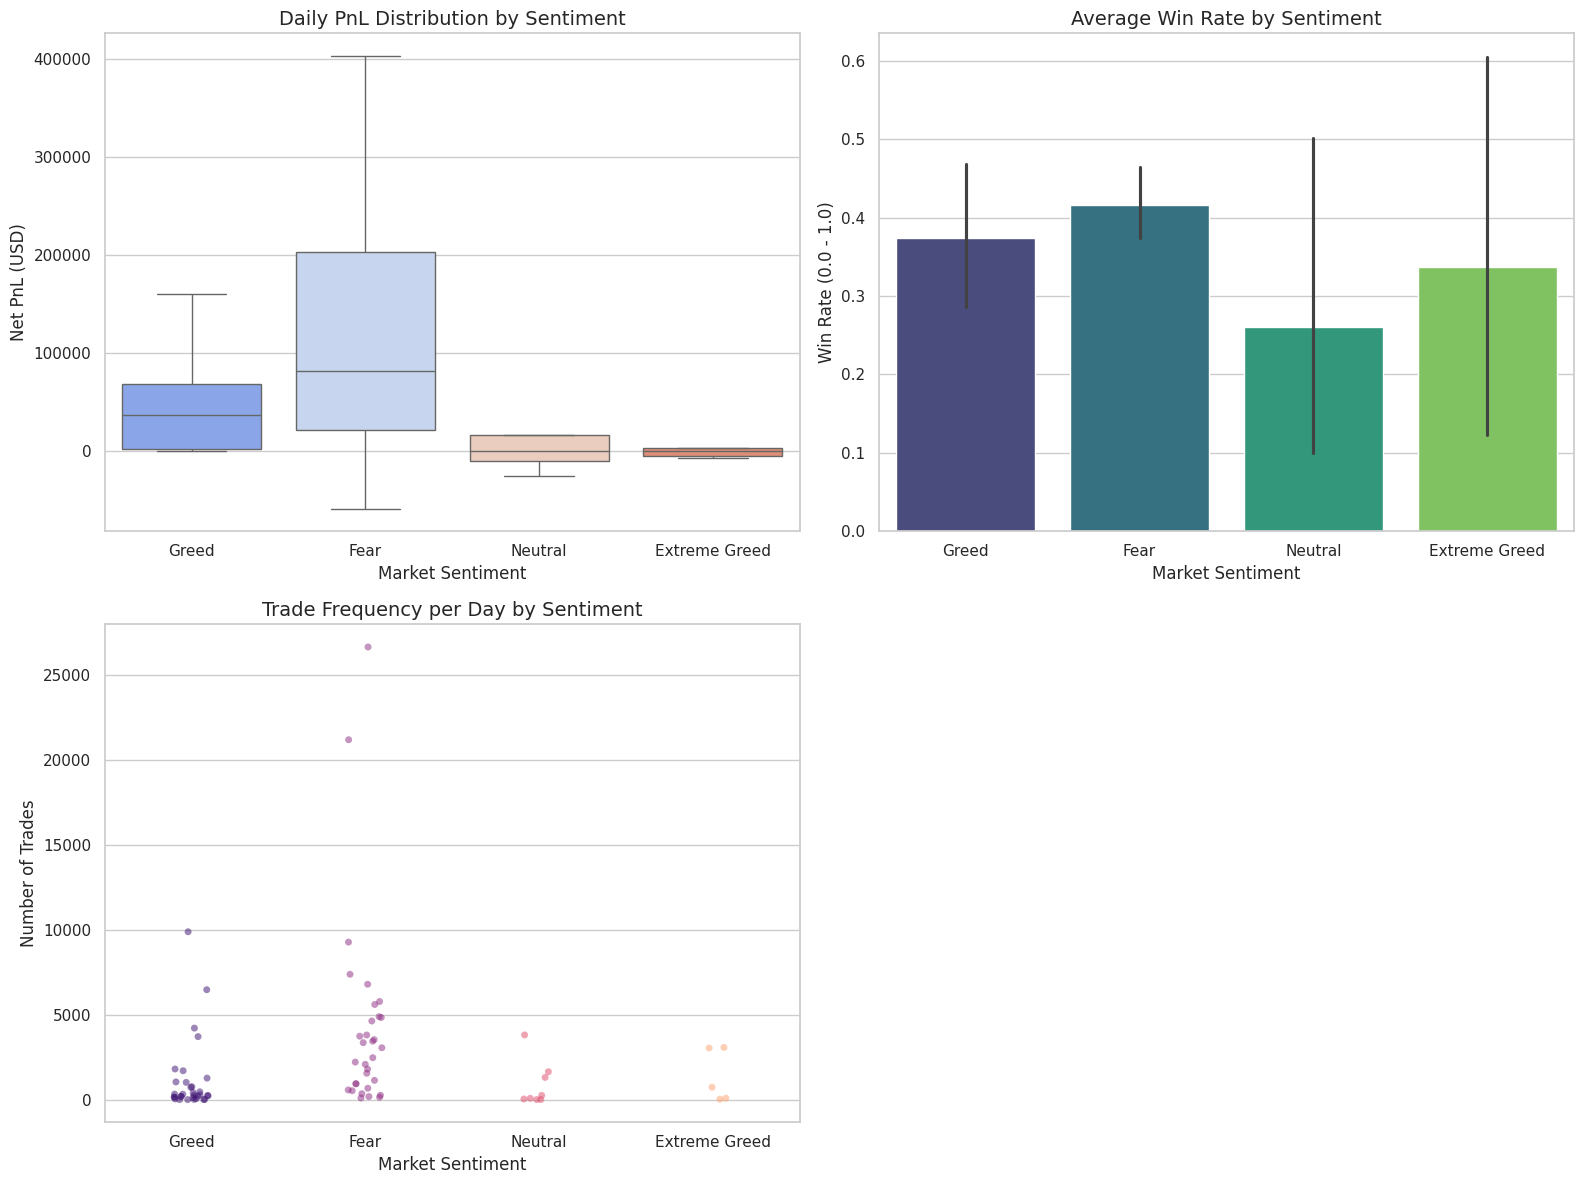

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(16, 12))

# --- Plot 1: Daily PnL Distribution by Sentiment ---
plt.subplot(2, 2, 1)
sns.boxplot(
    data=daily_metrics,
    x='classification',
    y='daily_pnl',
    hue='classification', # Fixes FutureWarning
    legend=False,         # Removes redundant legend
    showfliers=False,     # Removes extreme outliers to make the box clearer
    palette='coolwarm'
)
plt.title('Daily PnL Distribution by Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Net PnL (USD)')

# --- Plot 2: Average Win Rate by Sentiment ---
plt.subplot(2, 2, 2)
sns.barplot(
    data=daily_metrics,
    x='classification',
    y='win_rate',
    hue='classification', # Fixes FutureWarning
    legend=False,
    palette='viridis'
)
plt.title('Average Win Rate by Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Win Rate (0.0 - 1.0)')

# --- Plot 3: Trade Frequency (Activity Level) ---
# This shows if traders over-trade during Greed vs Fear
plt.subplot(2, 2, 3)
sns.stripplot(
    data=daily_metrics,
    x='classification',
    y='trade_count',
    hue='classification',
    jitter=True,
    alpha=0.5,
    palette='magma',
    legend=False
)
plt.title('Trade Frequency per Day by Sentiment', fontsize=14)
plt.xlabel('Market Sentiment')
plt.ylabel('Number of Trades')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
# Segment 1: Frequent vs Infrequent (based on median trades per day)
median_trades = daily_metrics['trade_count'].median()
daily_metrics['activity_segment'] = np.where(daily_metrics['trade_count'] > median_trades, 'High Freq', 'Low Freq')

# Segment 2: Profitability
daily_metrics['outcome_segment'] = np.where(daily_metrics['daily_pnl'] > 0, 'Winner', 'Loser')

# Analyze a segment: Do "High Freq" traders do better in Greed or Fear?
segment_analysis = daily_metrics.groupby(['activity_segment', 'classification'])['daily_pnl'].mean().unstack()
print("Average PnL per Segment/Sentiment:")
print(segment_analysis)

Average PnL per Segment/Sentiment:
classification    Extreme Greed           Fear          Greed       Neutral
activity_segment                                                           
High Freq          95224.489473  265107.235726  281689.454396   9156.505979
Low Freq           -4494.495724   42168.941645   28452.671557  26254.572028


In [ ]:
# Rule of Thumb Logic Example:
fear_pnl = daily_metrics[daily_metrics['classification'] == 'Fear']['daily_pnl'].mean()
greed_pnl = daily_metrics[daily_metrics['classification'] == 'Greed']['daily_pnl'].mean()

print(f"Insight: Average PnL during Fear is {fear_pnl:.2f} vs Greed {greed_pnl:.2f}")

# Propose a rule
if fear_pnl < greed_pnl:
    print("Recommendation: Implement a risk-off filter during 'Fear' days for high-frequency accounts.")
else:
    print("Recommendation: Volatility in 'Fear' days provides better entry points for mean-reversion strategies.")

Insight: Average PnL during Fear is 209372.66 vs Greed 99675.52
Recommendation: Volatility in 'Fear' days provides better entry points for mean-reversion strategies.


# New Section

In [13]:
# Save only the first 50,000 rows (or whatever fits under 100MB)
trader_df.head(50000).to_csv('historical_data_sample.csv', index=False)